# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import skimage

DATA_DIR = "project-data/"
IMAGES_DIR = "project-data/images/"
ANNOTATIONS_DIR = "project-data/annotations/"

In [51]:
def get_names(addresses_file):
    """
    Gathers the names of the dataset items contained in the given addresses file.
    Inputs:
        - addresses_file: file containing the names of the dataset items
    Output:
        - list of names of dataset items.
    """
    f = open(addresses_file, "r")
    return [name.strip() for name in f.readlines()]

def get_images(names, dir_path = IMAGES_DIR):
    """
    Gathers the images of the dataset items contained with given names contained in a given directory
    Inputs:
        - names: list of the names of the images to gather.
        - dir_path: directory containing the images.
    Output:
        - {name: image_array} like dictionary of images.
    """
    return {name: skimage.io.imread(dir_path + name + ".jpg") for name in names}

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

def get_annotations(names, dir_path = ANNOTATIONS_DIR):
    """
    Gathers the annotations of the dataset items contained with given names contained in a given directory
    Inputs:
        - names: list of the names of the annotations to gather.
        - dir_path: directory containing the annotations.
    Output:
        - {name: annotations_object} like dictionary of annotations.
    """
    return {name: parse_file(dir_path + name + ".xml") for name in names}

def plot_annotations(ax, annotations):
    """
    Plots the annotaions on the AxesSubplot object.
    Inputs:
        - ax: where to plot the annotaions.
        - annotations: annotations objects to plot.
    Output:
    """
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

def get_mask(img, annotations):
    """
    Gathers the mask of the image marking the annotated bounding boxes.
    Input:
        - img: image to mask (just for the shape)
        - annotations: bounding boxes objects to mark
    Output:
        - binary array of same shape as input image containing True wherever a bounding box is.
    """
    mask = np.zeros(img.shape[:2], "bool")
    for anno in annotations:
        mask[anno['bbox'][1]:anno['bbox'][1] + anno['bbox'][3], anno['bbox'][0]:anno['bbox'][0] + anno['bbox'][2]] = True
    return mask

In [26]:
# Gathers the names of the training dataset items
TRAINING_NAMES = get_names(DATA_DIR + "train.txt")
for name in TRAINING_NAMES[:5]:
    print(name)

5a4a025ca07d567e7d04bed7_32.00px_10
5a90628ea07d569183acf22b_32.00px_5
5984d23b579e529fdea8af09_32.00px_1
5a0de18fa07d56baef59b1f8_32.00px_11
5a3d5aeca07d567e7d04bea8_32.00px_3


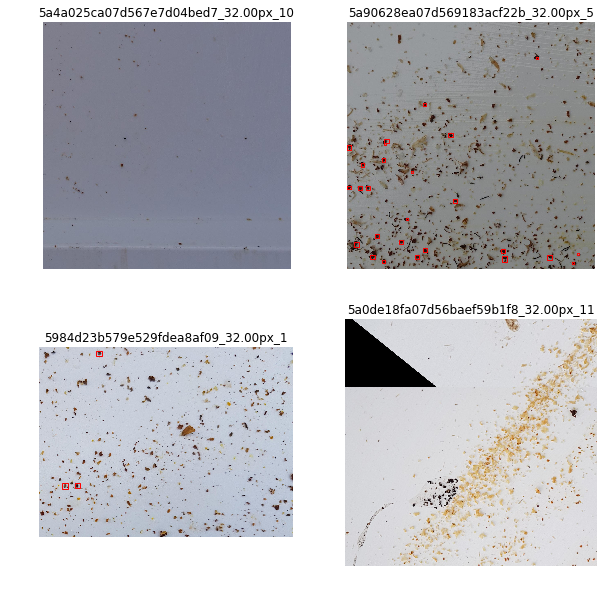

In [84]:
# Gathers some images
TRAINING_IMAGES = get_images(TRAINING_NAMES[:12], IMAGES_DIR + "train/")
TRAINING_ANNOTATIONS = get_annotations(TRAINING_NAMES[:12], ANNOTATIONS_DIR + "train/")

(nrows, ncols) = (2, 2)

# Plots the images and annotations
fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 5 * nrows))
k = 0
for i in range(nrows):
    for j in range(ncols):
        name = TRAINING_NAMES[k]
        ax[i, j].imshow(TRAINING_IMAGES[name])
        plot_annotations(ax[i, j], TRAINING_ANNOTATIONS[name])
        ax[i, j].axis('off')
        ax[i, j].set_title(name)
        k += 1
plt.show()

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [80]:
def show_histogram(img, mask, channel=0):
    """
    Shows histogram of input image on given channel
    Input: 
        - img: image to analyze
        - mask: binary array of same shape as img containing the positions of positive class pixels
        - channel: (int) channel (RGB) to consider
    Output: 
        - shows the histogram of pixels for positive and negative pixels.
    """
    pixels_mask = img[:, :, channel][ mask]
    pixels_comp = img[:, :, channel][~mask]
    
    plt.hist(pixels_mask, density=True, bins=100, alpha=0.5)
    plt.hist(pixels_comp, density=True, bins=100, alpha=0.5)
    
    plt.show()
    
def show_histogram2d(img, mask, channels=(0, 1)):
    """
    Shows 2D-histogram of input image on given channels
    Input: 
        - img: image to analyze
        - mask: binary array of same shape as img containing the positions of positive class pixels
        - channels: (int, int) channels (RGB) to consider
    Output: 
        - shows the 2D-histogram of pixels for positive and negative pixels.
    """
    pixels_mask0 = img[:, :, channels[0]][ mask]
    pixels_comp0 = img[:, :, channels[0]][~mask]
    
    pixels_mask1 = img[:, :, channels[1]][ mask]
    pixels_comp1 = img[:, :, channels[1]][~mask]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].hist2d(pixels_mask0, pixels_mask1, bins=100)
    ax[1].hist2d(pixels_comp0, pixels_comp1, bins=100)
    
    plt.show()

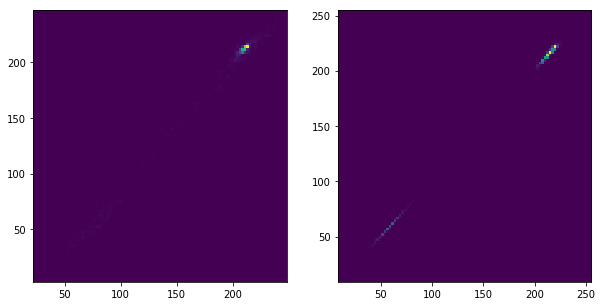

In [82]:
name = TRAINING_NAMES[5]
img = TRAINING_IMAGES[name]
annotations = TRAINING_ANNOTATIONS[name]
mask = get_mask(img, annotations)
show_histogram2d(img, mask, (0, 1))

In [1]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [2]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code